# 06. Trajectory Models

## Objective
Build and evaluate machine learning models to classify the financial trajectory of NCAA athletic departments.

## Inputs
- `trajectory_ml_ready.csv`: The feature-engineered dataset.

## Steps
1. **Load Data**: Read the prepared dataset.
2. **Preprocessing**: Handle categorical variables, scaling, and train/test split.
3. **Model Training**: Train Logistic Regression, Random Forest, and XGBoost models.
4. **Evaluation**: Compare models using Accuracy, Precision, Recall, F1-Score, and ROC-AUC.
5. **Feature Importance**: Analyze which features drive the predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Set plot style
sns.set(style="whitegrid")

## 1. Load Data

In [2]:
# Load the dataset
df = pd.read_csv('trajectory_ml_ready.csv')

# Display basic info
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (12054, 20)


,UNITID,Institution_Name,Year,State,Division,Grand Total Revenue,Grand Total Expenses,Total_Athletes,Revenue_Growth_1yr,Expense_Growth_1yr,Revenue_CAGR_2yr,Expense_CAGR_2yr,Revenue_Mean_2yr,Expense_Mean_2yr,Efficiency_Mean_2yr,Revenue_Volatility_2yr,Expense_Volatility_2yr,Reports_Exactly_One,Target_Trajectory,Target_Label
0,100654,Alabama A & M University,2016,AL,D1,9333489,9333489,314,-0.073843,-0.073843,-0.061582,-0.061582,9705573.0,9705573.0,1.000000,5.262062e+05,5.262062e+05,1,Stable,1.0
1,100654,Alabama A & M University,2017,AL,D1,9422876,9422876,349,0.009577,0.009577,-0.033032,-0.033032,9378182.5,9378182.5,1.000000,6.320615e+04,6.320615e+04,1,Improving,2.0
2,100654,Alabama A & M University,2018,AL,D1,13790500,13626724,281,0.463513,0.446132,0.215536,0.208297,11606688.0,11524800.0,1.006009,3.088377e+06,2.972569e+06,0,Stable,1.0
3,100654,Alabama A & M University,2019,AL,D1,14440268,14440268,312,0.047117,0.059702,0.237929,0.237929,14115384.0,14033496.0,1.006009,4.594554e+05,5.752625e+05,1,Declining,0.0
4,100654,Alabama A & M University,2020,AL,D1,10055044,10055044,296,-0.303680,-0.303680,-0.146110,-0.140994,12247656.0,12247656.0,1.000000,3.100822e+06,3.100822e+06,1,Improving,2.0


## 2. Preprocessing

In [3]:
# Define features and target
# Dropping non-predictive columns or identifiers
# Corrected column names based on CSV inspection
drop_cols = ['UNITID', 'Institution_Name', 'Year', 'Target_Trajectory', 'Target_Label', 'State']

X = df.drop(columns=drop_cols)
y = df['Target_Label']

# Encode categorical variables (e.g., Division)
X = pd.get_dummies(X, columns=['Division'], drop_first=True)

# Check for any remaining non-numeric columns
print("Features:", X.columns.tolist())
print("\nMissing Values:\n", X.isnull().sum().sum())

Features: ['Grand Total Revenue', 'Grand Total Expenses', 'Total_Athletes', 'Revenue_Growth_1yr', 'Expense_Growth_1yr', 'Revenue_CAGR_2yr', 'Expense_CAGR_2yr', 'Revenue_Mean_2yr', 'Expense_Mean_2yr', 'Efficiency_Mean_2yr', 'Revenue_Volatility_2yr', 'Expense_Volatility_2yr', 'Reports_Exactly_One', 'Division_Other', 'Division_Unknown']

Missing Values:
 0


In [4]:
# Train-Test Split
# Using Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training Set: {X_train.shape}")
print(f"Testing Set: {X_test.shape}")

Training Set: (9643, 15)
Testing Set: (2411, 15)


## 3. Model Training & Evaluation
We will test three models:
1. **Logistic Regression**: Baseline linear model.
2. **Random Forest**: Ensemble method, good for non-linear relationships.
3. **XGBoost**: Gradient boosting, often high performance.

We will use **SMOTE** (Synthetic Minority Over-sampling Technique) within a pipeline to address the class imbalance observed in EDA.

In [5]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    print(f"--- {model_name} ---")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    if y_prob is not None:
        # Calculate ROC-AUC for multi-class
        try:
            auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
            print(f"ROC-AUC Score: {auc:.4f}")
        except ValueError:
            print("Could not calculate ROC-AUC")
    print("\n")

# 1. Logistic Regression
pipeline_lr = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_lr.fit(X_train, y_train)
evaluate_model(pipeline_lr, X_test, y_test, "Logistic Regression")

# 2. Random Forest
pipeline_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline_rf.fit(X_train, y_train)
evaluate_model(pipeline_rf, X_test, y_test, "Random Forest")

# 3. XGBoost
pipeline_xgb = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

pipeline_xgb.fit(X_train, y_train)
evaluate_model(pipeline_xgb, X_test, y_test, "XGBoost")

--- Logistic Regression ---
              precision    recall  f1-score   support

         0.0       0.78      0.17      0.27       944
         1.0       0.61      0.76      0.68      1139
         2.0       0.26      0.62      0.36       328

    accuracy                           0.51      2411
   macro avg       0.55      0.51      0.44      2411
weighted avg       0.63      0.51      0.48      2411

Confusion Matrix:
[[157 458 329]
 [ 17 865 257]
 [ 27  98 203]]
ROC-AUC Score: 0.6766


--- Random Forest ---
              precision    recall  f1-score   support

         0.0       0.52      0.41      0.46       944
         1.0       0.64      0.64      0.64      1139
         2.0       0.27      0.43      0.33       328

    accuracy                           0.52      2411
   macro avg       0.48      0.49      0.48      2411
weighted avg       0.54      0.52      0.53      2411

Confusion Matrix:
[[386 342 216]
 [241 730 168]
 [115  72 141]]
ROC-AUC Score: 0.6803




/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [10:33:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost ---
              precision    recall  f1-score   support

         0.0       0.54      0.40      0.46       944
         1.0       0.63      0.65      0.64      1139
         2.0       0.25      0.41      0.31       328

    accuracy                           0.52      2411
   macro avg       0.47      0.49      0.47      2411
weighted avg       0.54      0.52      0.52      2411

Confusion Matrix:
[[373 348 223]
 [214 739 186]
 [105  88 135]]
ROC-AUC Score: 0.6831




## 4. Feature Importance
Let's look at what features are driving the Random Forest model.

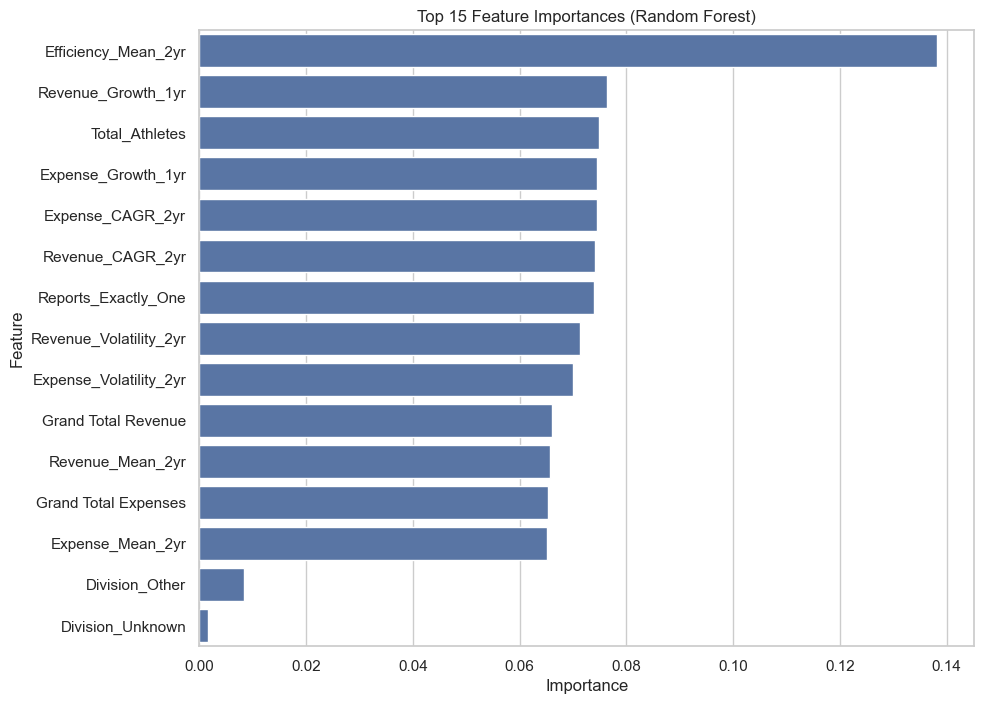

In [6]:
# Extract feature importance from Random Forest
rf_model = pipeline_rf.named_steps['classifier']
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()